In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

In [3]:
def shorten_protocol_name(x: str):
    val = x.replace("Protocol","").replace("spreading_proba","p")
    val = val.split("broadcast")[0][:-1].replace("(", ": ")
    if val[-1] == ",":
        val = val[:-1]
    return val

In [4]:
nw_generator = NodeWeightGenerator("random")
ew_generator = EdgeWeightGenerator("normal")

# Dandelion example

In [20]:
net = Network(nw_generator, ew_generator, num_nodes=1000, k=20)

In [21]:
dp = DandelionProtocol(net, 0.5)

dp = DandelionPlusPlusProtocol(net, 0.5)

nx.draw(dp.anonymity_graph, node_size=20)

In [22]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 30, verbose=False)
sim.run()

CPU times: user 3.96 s, sys: 48.7 ms, total: 4.01 s
Wall time: 4.01 s


[0.965,
 0.984,
 0.976,
 0.986,
 0.978,
 0.987,
 0.981,
 0.971,
 0.978,
 0.984,
 0.982,
 0.988,
 0.984,
 0.972,
 0.982,
 0.993,
 0.978,
 0.984,
 0.977,
 0.988,
 0.977,
 0.972,
 0.978,
 0.972,
 0.988,
 0.978,
 0.986,
 0.99,
 0.988,
 0.982]

In [23]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.23333333333333334, 'inverse_rank': 0.2363067746818181, 'entropy': 0.0, 'ndcg': 0.32425858846820066, 'message_spread_ratio': 0.9809666666666667}
CPU times: user 82.4 ms, sys: 8.42 ms, total: 90.8 ms
Wall time: 88.9 ms


In [24]:
%%time
evaluator = Evaluator(sim, "first_sent")
print(evaluator.get_report())

{'estimator': 'first_sent', 'hit_ratio': 0.5333333333333333, 'inverse_rank': 0.5357903896324353, 'entropy': 0.0, 'ndcg': 0.5918810076981555, 'message_spread_ratio': 0.9809666666666667}
CPU times: user 28.7 ms, sys: 114 µs, total: 28.8 ms
Wall time: 28.3 ms


In [25]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.00599769924208568, 'entropy': 6.802394763324314, 'ndcg': 0.12382128023983857, 'message_spread_ratio': 0.9809666666666667}
CPU times: user 49 ms, sys: 3.42 ms, total: 52.4 ms
Wall time: 50.4 ms


# Spreading time experiment

100
1.0
1.0
1.0
1.0
1.0
CPU times: user 539 ms, sys: 11.5 ms, total: 550 ms
Wall time: 543 ms


Text(0.5, 0, 'quantiles')

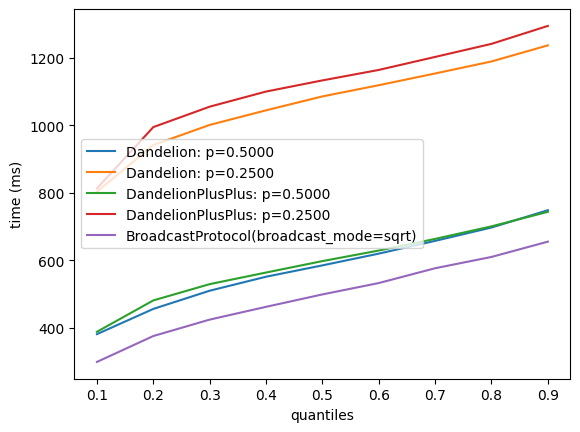

In [12]:
%%time
bc_mode="sqrt"
net = Network(nw_generator, ew_generator, num_nodes=100, k=10)
print(net.num_nodes)
protocols = [
    DandelionProtocol(net, 0.5, broadcast_mode=bc_mode),
    DandelionProtocol(net, 0.25, broadcast_mode=bc_mode),
    DandelionPlusPlusProtocol(net, 0.5, broadcast_mode=bc_mode),
    DandelionPlusPlusProtocol(net, 0.25, broadcast_mode=bc_mode),
    BroadcastProtocol(net, broadcast_mode=bc_mode)
]

for protocol in protocols:
    sim = Simulator(protocol, adv, 10, verbose=False)
    msg_cov = sim.run(coverage_threshold=1.0)
    #print(msg_cov)
    print(np.mean(msg_cov))
    x = np.arange(0.1,1.0,0.1)
    mean_quantiles, std_quantiles = sim.node_contact_time_quantiles(x)
    name = shorten_protocol_name(str(protocol)) if not "Broadcast" in str(protocol) else str(protocol)
    plt.plot(x, mean_quantiles, label=name)
plt.legend()
plt.ylabel("time (ms)")
plt.xlabel("quantiles")

# Experiment example

In [13]:
network_size = 1000
num_msg = int(network_size*0.05)
degree = 50
num_trials = 10
adversary_ratios = [0.01,0.05,0.1,0.2]
bc_mode = "sqrt"
dandelion_bc_probas = [0.5, 0.25, 0.1]

In [14]:
print(num_msg)

50


In [15]:
from tqdm.notebook import tqdm

### Messages are propagated until full coverage

In [16]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, num_msg, verbose=False)
    sim.run(coverage_threshold=1.0)
    reports = []
    for estimator in ["first_reach","first_sent"]:
        evaluator = Evaluator(sim, estimator)
        report = evaluator.get_report()
        report["protocol"] = str(protocol)
        report["adversary_ratio"] = adv.ratio
        reports.append(report)
    return reports, sim

In [17]:
def run_experiment(adversary_ratios, is_active_adversary=False):
    results = []
    # it could be parallelized
    for adv_ratio in adversary_ratios:
        for _ in tqdm(range(num_trials)):
            # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
            net = Network(nw_generator, ew_generator, network_size, degree)
            adv = Adversary(net, adv_ratio, is_active_adversary)
            protocols = [BroadcastProtocol(net, broadcast_mode=bc_mode)]
            for broadcast_proba in dandelion_bc_probas:
                protocols.append(DandelionProtocol(net, broadcast_proba, broadcast_mode=bc_mode))
                protocols.append(DandelionPlusPlusProtocol(net, broadcast_proba, broadcast_mode=bc_mode))
            for protocol in protocols:
                new_reports, sim = run_and_eval(net, adv, protocol)
                results += new_reports
        print(adv_ratio)
    results_df = pd.DataFrame(results)
    return results_df

In [18]:
%%time
results_df = run_experiment(adversary_ratios)

  0%|          | 0/10 [00:00<?, ?it/s]

0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0.1


  0%|          | 0/10 [00:00<?, ?it/s]

0.2
CPU times: user 40min 34s, sys: 2.94 s, total: 40min 37s
Wall time: 40min 35s


In [19]:
def shorten_protocol_names_for_df(df, col="protocol"):
    tmp_df = df.copy()
    tmp_df[col] = tmp_df[col].apply(shorten_protocol_name)
    return tmp_df

In [20]:
results_df_short = shorten_protocol_names_for_df(results_df)

In [21]:
fr_results_df = results_df_short[results_df_short["estimator"]=="first_reach"]
fs_results_df = results_df_short[results_df_short["estimator"]=="first_sent"]
print(fr_results_df.shape, fs_results_df.shape)

(280, 8) (280, 8)


## a.) Adversary performance

- First-sent estimator performs better than first reach - **OK**

In [22]:
fr_results_df_short = shorten_protocol_names_for_df(fr_results_df)
fs_results_df_short = shorten_protocol_names_for_df(fs_results_df)

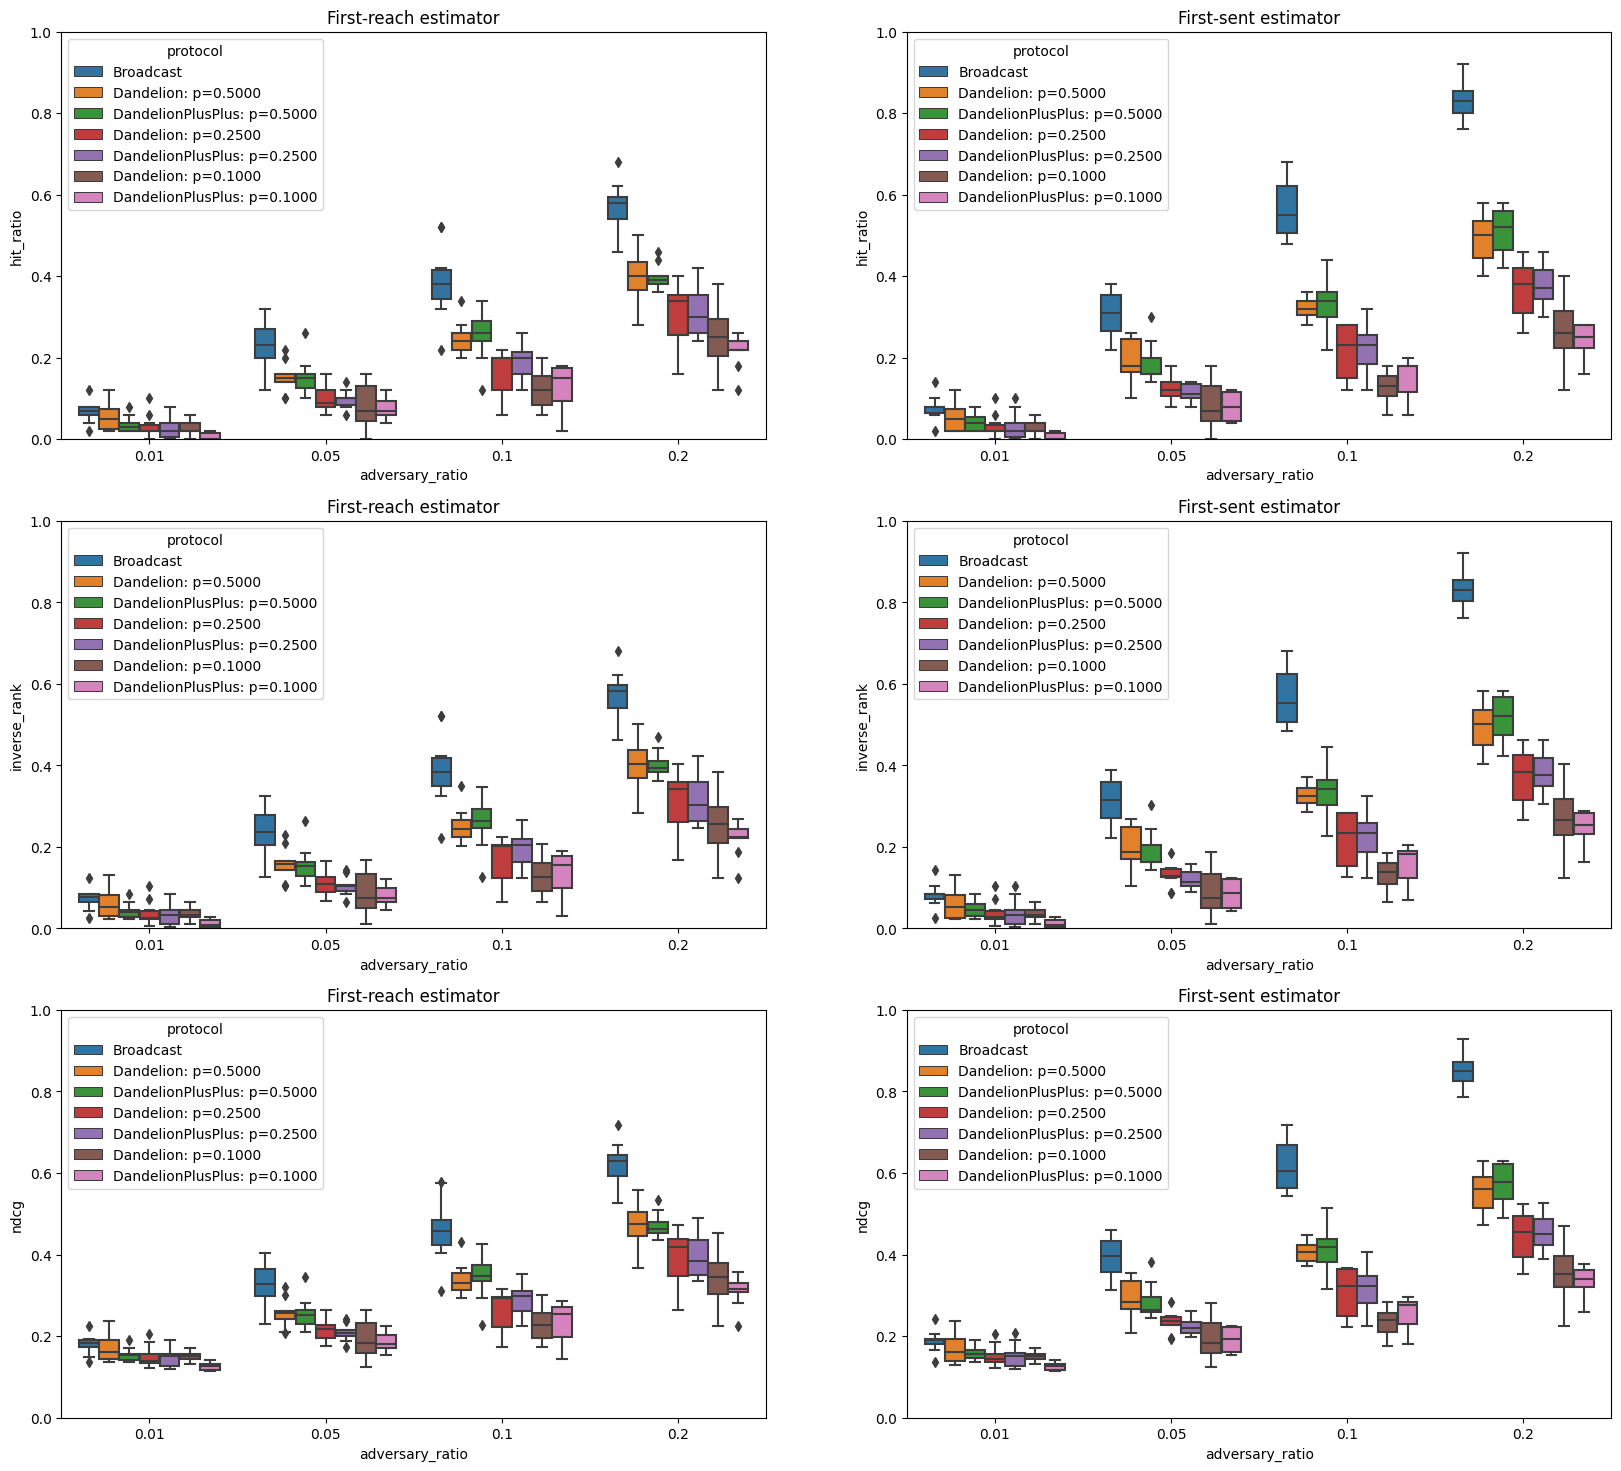

In [23]:
fig, ax = plt.subplots(3,2, figsize=(20,18))
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][0])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][1])
for i in range(3):
    for j in range(2):
        ax[i][j].set_title("First-reach estimator" if j % 2 == 0 else "First-sent estimator")
        ax[i][j].set_ylim(0,1.0)

While the fraction of nodes reached by messages are the same range for all protocols:
- actually, almost all nodes are reached by the messages (due to `coverage_threshold=1.0` setting) - **OK**

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

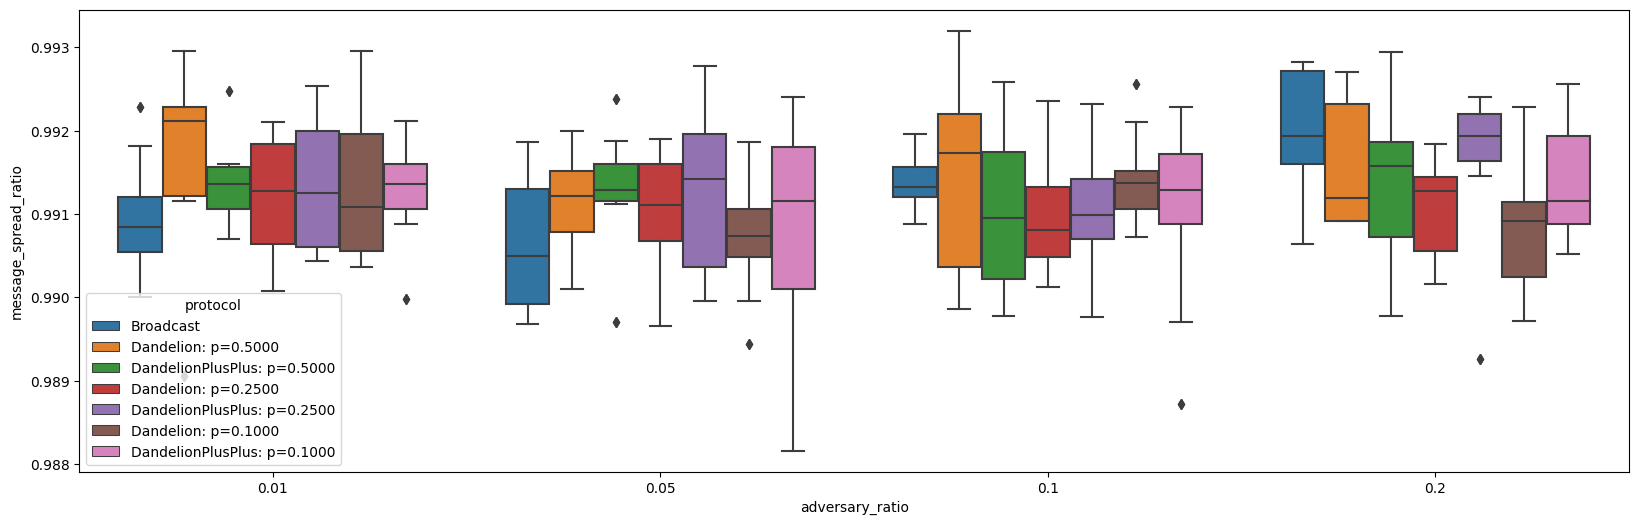

In [24]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.boxplot(data=results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)

## b.) Passive vs. active adversary

**active adversary:** simply does not forward the received message

**passive adversary:** forwards every message according to protocol rules

In [25]:
%%time
active_results_df = run_experiment(adversary_ratios, True)
active_results_df = active_results_df[active_results_df["estimator"]=="first_sent"]
active_results_df.shape

  0%|          | 0/10 [00:00<?, ?it/s]

0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0.1


  0%|          | 0/10 [00:00<?, ?it/s]

0.2
CPU times: user 31min 44s, sys: 1.92 s, total: 31min 45s
Wall time: 31min 44s


(280, 8)

In [26]:
active_results_df_short = shorten_protocol_names_for_df(active_results_df)

The results show that **longer stem-phase in the Dandelion protocol** (low broadcast probability) **have a negative impact on the message spread ratio** (ratio of all nodes who receives the message) - as expected.

(0.1, 1.0)

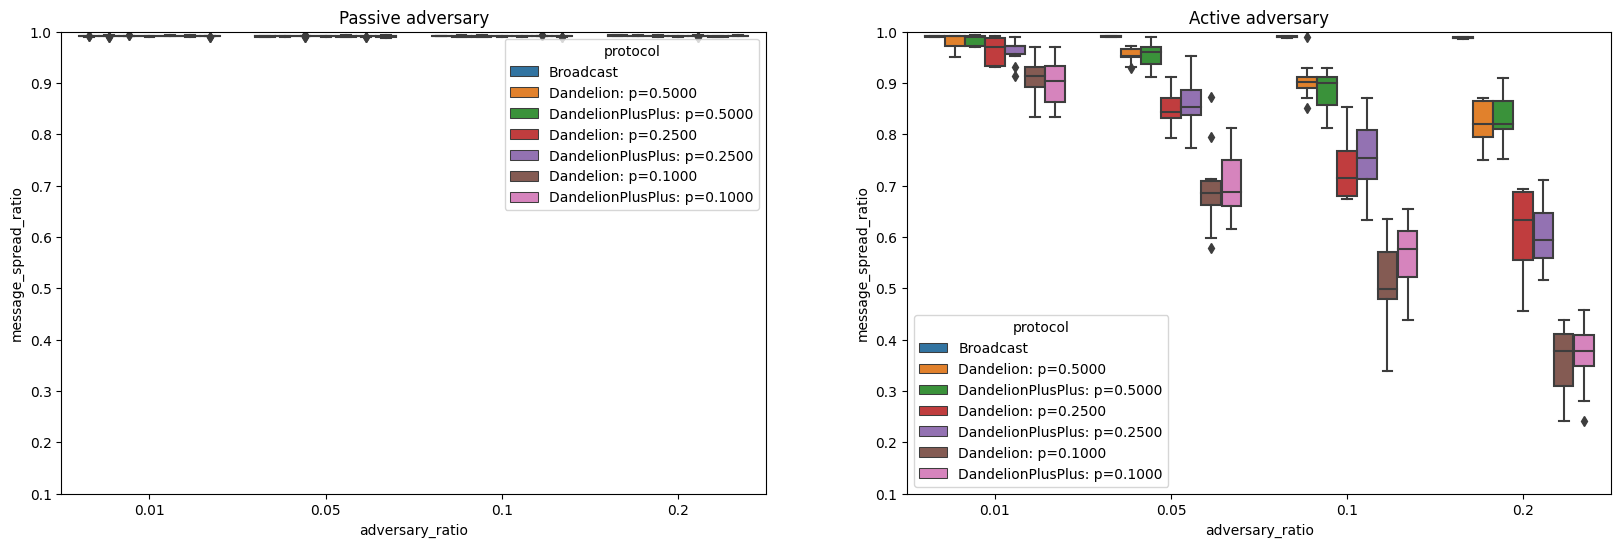

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.boxplot(data=results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax[0])
ax[0].set_title("Passive adversary")
ax[0].set_ylim(0.1,1.0)
sns.boxplot(data=active_results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax[1])
ax[1].set_title("Active adversary")
ax[1].set_ylim(0.1,1.0)

In [28]:
import sys, os, pytest

sys.path.insert(0, "%s/python" % os.getcwd())
import networkx as nx
from network import Network, NodeWeightGenerator, EdgeWeightGenerator
from simulator import Simulator, Evaluator
from message import Message
from protocols import BroadcastProtocol, DandelionProtocol, DandelionPlusPlusProtocol
from adversary import Adversary

None
[3]
0 1 {1: [ProtocolEvent(1, 1, 0.000000, 0)]}
1 2 {1: [ProtocolEvent(1, 1, 0.000000, 0)], 2: [ProtocolEvent(1, 2, 0.900000, 1)]}
2 2 {1: [ProtocolEvent(1, 1, 0.000000, 0)], 2: [ProtocolEvent(1, 2, 0.900000, 1)], 3: [ProtocolEvent(1, 3, 1.840000, 1)]}
3 2 {1: [ProtocolEvent(1, 1, 0.000000, 0)], 2: [ProtocolEvent(1, 2, 0.900000, 1)], 3: [ProtocolEvent(1, 3, 1.840000, 1)]}


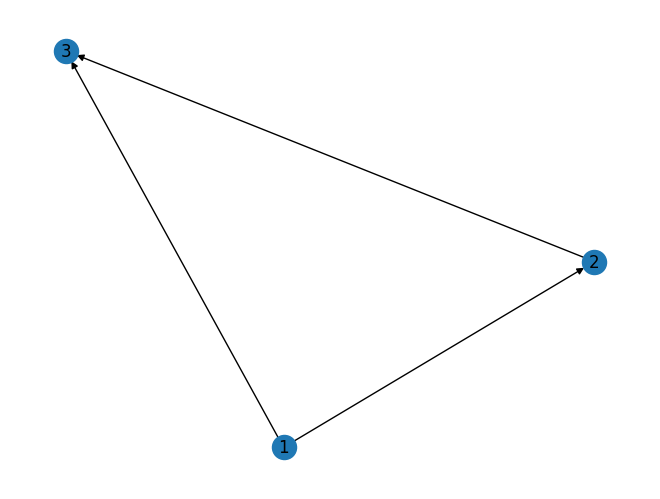

In [29]:
### First sent vs First reach test
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84),(2, 3, 1.01)], weight="latency")
print(nx.draw(G,with_labels=True))
net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, seed=44)
adv = Adversary(net, ratio=0.0, adversaries=[2])
print(adv.nodes)
assert 3 in adv.nodes

# start a message from Node 1
msg = Message(1)
receiver_order = [1, 2, 2, 2]
for i, receiver in enumerate(receiver_order):
    msg.process(protocol, adv)
    print(i,receiver,msg.history)
    assert receiver in msg.history
    # assert len(msg.history) == i + 1

In [30]:
sim = Simulator(protocol, adv, 1, True)
sim.run(1.0)
for estimator in ["first_reach", "first_sent"]:
    evaluator = Evaluator(sim, estimator)
    results = [
        evaluator.exact_hits,
        evaluator.ranks,
        evaluator.inverse_ranks,
        evaluator.entropies,
    ]
    for i in results:
        print(estimator, i)

a44d8386208c428bb1df0384bf1feae5 0.3333333333333333 0
a44d8386208c428bb1df0384bf1feae5 0.6666666666666666 0

first_reach [1.]
first_reach [1.]
first_reach [1.]
first_reach [0.]
first_sent [1.]
first_sent [1.]
first_sent [1.]
first_sent [0.]
